In [31]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


In [32]:

zip_file_path = '/content/heart+disease.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Get a list of file names in the zip file
    file_names = zip_ref.namelist()

    # Choose the file to read (e.g., the first file)
    file_to_read = file_names[0]

    # Read the selected file into a pandas DataFrame
    data = pd.read_csv(zip_ref.open(file_to_read))

data.head()

,Index of heart-disease
0,02 Dec 1996 644 Index
1,02 Dec 1996 dir costs
2,23 Jul 1996 11058 reprocessed.hungarian.data
3,14 Aug 1991 6737 bak
4,14 Aug 1991 10263 processed.hungarian.data


In [34]:
import zipfile

zip_file_path = '/content/heart+disease.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Get a list of file names in the zip file
    file_names = zip_ref.namelist()

# Print the list of files
print("Files in the zip archive:", file_names)

Files in the zip archive: ['Index', 'WARNING', 'ask-detrano', 'bak', 'cleve.mod', 'cleveland.data', 'costs/', 'costs/Index', 'costs/heart-disease.README', 'costs/heart-disease.cost', 'costs/heart-disease.delay', 'costs/heart-disease.expense', 'costs/heart-disease.group', 'heart-disease.names', 'hungarian.data', 'long-beach-va.data', 'new.data', 'processed.cleveland.data', 'processed.hungarian.data', 'processed.switzerland.data', 'processed.va.data', 'reprocessed.hungarian.data', 'switzerland.data']


In [35]:
# Utility helpers (plots, reporting, safe casting)
import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)

# Define BASE directory
BASE = "." # Using the current directory as the base

RESULTS_DIR = f"{BASE}/results"
MODELS_DIR = f"{BASE}/models"

def save_plot(fname):
    path = f"{RESULTS_DIR}/{fname}"
    plt.savefig(path, bbox_inches="tight", dpi=140)
    print("Saved:", path)

def print_and_save_metrics(name, y_true, y_pred, y_prob=None, out_txt="evaluation_metrics.txt"):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob) if y_prob is not None else None

    block = [
        f"=== {name} ===",
        f"Accuracy : {acc:.4f}",
        f"Precision: {prec:.4f}",
        f"Recall   : {rec:.4f}",
        f"F1-score : {f1:.4f}",
        f"AUC      : {auc:.4f}" if auc is not None else "AUC      : N/A",
        "Classification Report:",
        classification_report(y_true, y_pred, digits=4)
    ]
    text = "\n".join(block) + "\n\n"

    print(text)
    with open(f"{RESULTS_DIR}/{out_txt}", "a") as f:
        f.write(text)

def safe_numeric(df):
    # Coerce all to numeric where possible (UCI sometimes uses '?')
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="ignore")
    return df

In [36]:
import zipfile
import pandas as pd

zip_file_path = '/content/heart+disease.zip'

# Load the processed.cleveland.data file from the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    with zip_ref.open('processed.cleveland.data') as f:
        # Assuming the data is comma-separated and has no header
        data = pd.read_csv(f, header=None)

print(data.shape)
display(data.head())

(303, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [37]:
# === C2) Quick info & missing values ===
data = safe_numeric(data)
print(data.info())
print("\nMissing values per column:\n", data.replace("?", np.nan).isna().sum())

# Replace '?' with NaN and convert
data = data.replace("?", np.nan)
for col in data.columns:
    # If still object after replacing '?', try to numeric, else leave as categorical
    try:
        data[col] = pd.to_numeric(data[col])
    except:
        pass

print("\nAfter coercion:")
print(data.info())
print("\nNull counts:\n", data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       303 non-null    float64
 1   1       303 non-null    float64
 2   2       303 non-null    float64
 3   3       303 non-null    float64
 4   4       303 non-null    float64
 5   5       303 non-null    float64
 6   6       303 non-null    float64
 7   7       303 non-null    float64
 8   8       303 non-null    float64
 9   9       303 non-null    float64
 10  10      303 non-null    float64
 11  11      303 non-null    object 
 12  12      303 non-null    object 
 13  13      303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
None

Missing values per column:
 0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    4
12    2
13    0
dtype: int64

After coercion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 

Saved: ./results/correlation_heatmap.png


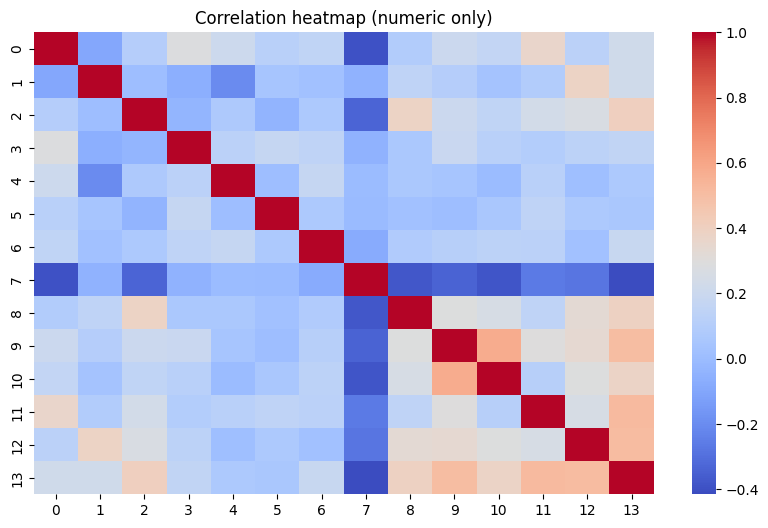

Saved: ./results/histograms.png


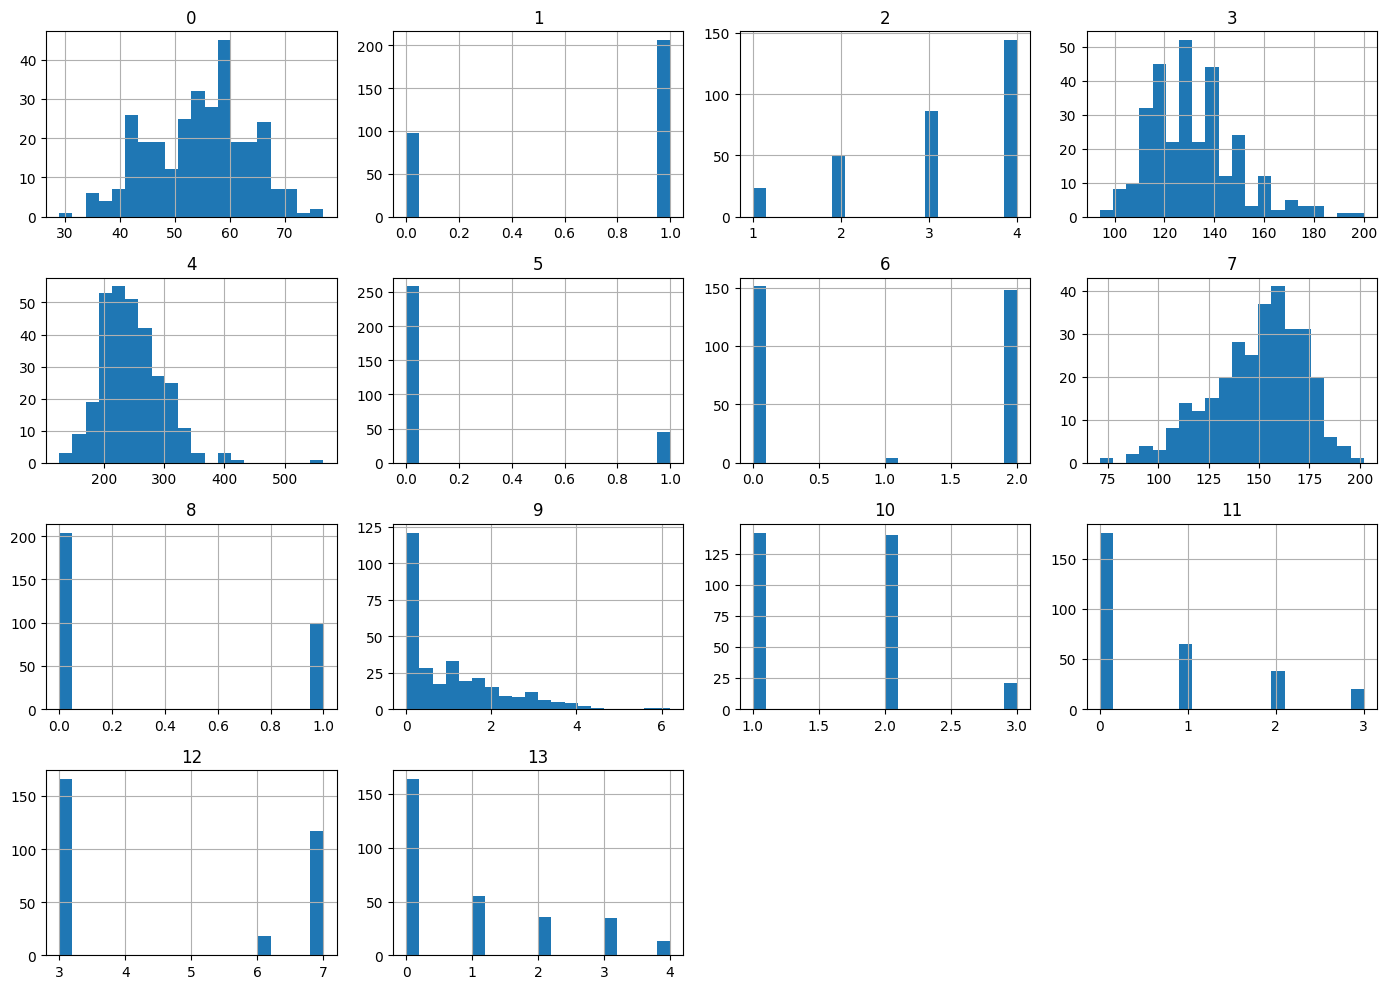

In [38]:
import os

# Create the results directory if it doesn't exist
os.makedirs(RESULTS_DIR, exist_ok=True)

# Now run the plotting code again
plt.figure(figsize=(10,6))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation heatmap (numeric only)")
save_plot("correlation_heatmap.png")
plt.show()

data.select_dtypes(include=[np.number]).hist(figsize=(14,10), bins=20)
plt.tight_layout()
save_plot("histograms.png")
plt.show()

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# === D1) Identify target and features
# Common UCI target column is named 'target' or 'num' (where num>0 means disease).
# Try to auto-detect; if your CSV uses another name, set TARGET manually.
TARGET = None
for cand in ["target", "num", "Diagnosis", "HeartDisease", "output"]:
    if cand in data.columns:
        TARGET = cand
        break

if TARGET is None:
    raise ValueError("Couldn't auto-detect target column. Rename your label column to 'target' or set TARGET manually.")

# Binarize the target variable: 0 becomes 0, values > 0 become 1
data[TARGET] = (data[TARGET] > 0).astype(int)


# Train/test split BEFORE scaling/encoding to avoid leakage
X = data.drop(columns=[TARGET])
y = data[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# === D2) Define numeric & categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

# === D3) Build preprocessing: impute + encode + scale
numeric_tf = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_tf = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, numeric_cols),
        ("cat", categorical_tf, categorical_cols)
    ]
)

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("\nBinarized Target Distribution:\n", y.value_counts())

Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical columns: []

Binarized Target Distribution:
 target
0    164
1    139
Name: count, dtype: int64


Saved: ./results/pca_cumulative_variance.png


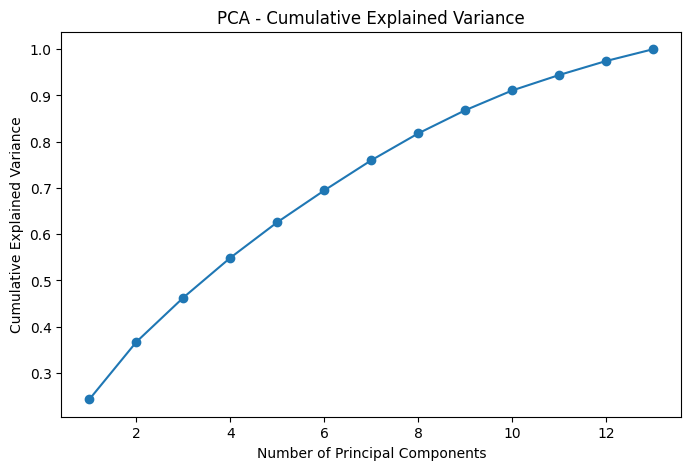

Saved: ./results/pca_2d_scatter.png


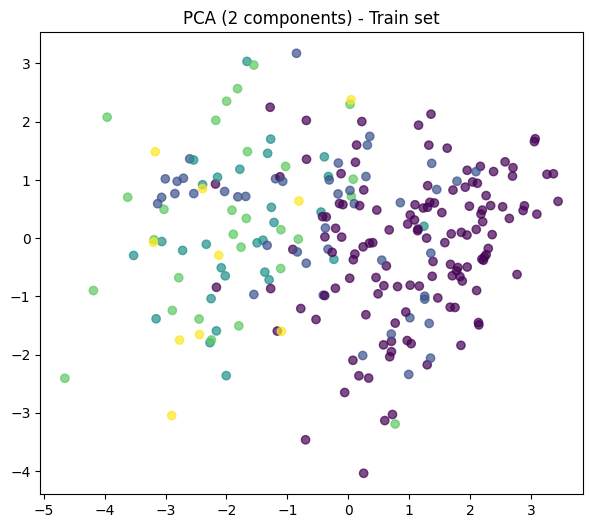

In [40]:
from sklearn.decomposition import PCA

# Fit preprocessor on train; transform both
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# PCA for analysis (not necessarily used in final model)
pca = PCA(n_components=None, random_state=42)
pca.fit(X_train_prep)

# Calculate cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
save_plot("pca_cumulative_variance.png")
plt.show()

# 2D projection (first two PCs)
X_train_pca2 = PCA(n_components=2, random_state=42).fit_transform(X_train_prep)
plt.figure(figsize=(7,6))
plt.scatter(X_train_pca2[:,0], X_train_pca2[:,1], c=y_train, alpha=0.7)
plt.title("PCA (2 components) - Train set")
save_plot("pca_2d_scatter.png")
plt.show()

Saved: ./results/rf_feature_importances.png


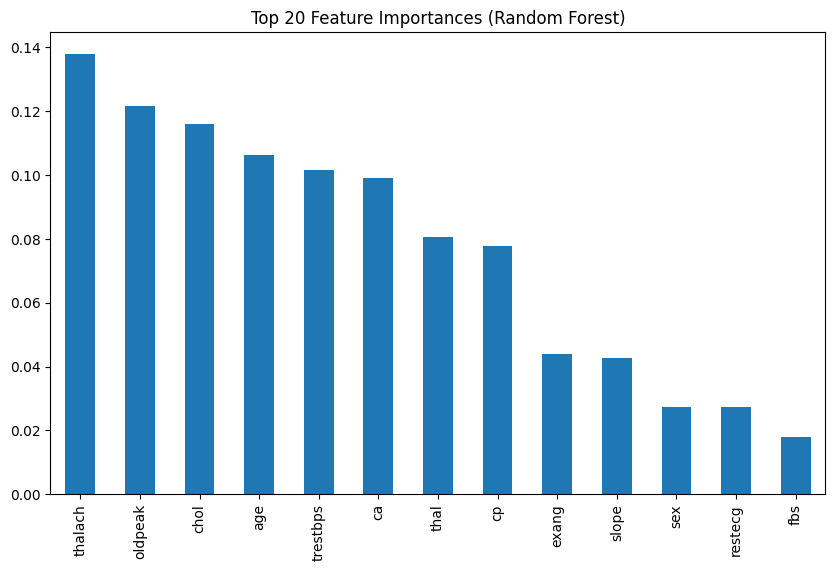

RFE selected features: ['sex', 'cp', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Chi2 selected features: ['sex', 'cp', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [47]:
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd # Import pandas if not already imported

# === F1) Random Forest importance on preprocessed features ===
# Use Random Forest to get feature importances
rf_tmp = RandomForestClassifier(n_estimators=300, random_state=42)
rf_tmp.fit(X_train_prep, y_train)
importances = rf_tmp.feature_importances_

# Get feature names after preprocessing
# This part reconstructs the feature names including one-hot encoded categories
ohe = preprocessor.named_transformers_["cat"]["encode"] if len(categorical_cols) else None
num_feat_names = numeric_cols
cat_feat_names = list(ohe.get_feature_names_out(categorical_cols)) if ohe is not None else []
feat_names = num_feat_names + cat_feat_names

# Create a pandas Series for easier visualization and sorting
imp_series = pd.Series(importances, index=feat_names).sort_values(ascending=False)

# Plot the top 20 feature importances
plt.figure(figsize=(10,6))
imp_series.head(20).plot(kind="bar")
plt.title("Top 20 Feature Importances (Random Forest)")
save_plot("rf_feature_importances.png")
plt.show()

# === F2) RFE with Logistic Regression ===
# Use Recursive Feature Elimination (RFE) with Logistic Regression
lr_base = LogisticRegression(max_iter=2000, solver="liblinear")
# We run RFE on the preprocessed matrix
rfe = RFE(lr_base, n_features_to_select=min(10, X_train_prep.shape[1])) # Select top 10 features or fewer if total is less than 10
rfe.fit(X_train_prep, y_train)

# Get the names of the features selected by RFE
rfe_selected = np.array(feat_names)[rfe.support_]
print("RFE selected features:", rfe_selected.tolist())

# === F3) Chi-Square (requires non-negative; use MinMax) ===
# Use Chi-Squared test for feature selection (suitable for non-negative data)
minmax = MinMaxScaler() # Use MinMaxScaler to ensure non-negativity for Chi-Square
X_train_mm = minmax.fit_transform(X_train_prep)
k = min(10, X_train_mm.shape[1]) # Select top k features, capped at 10
chi = SelectKBest(score_func=chi2, k=k).fit(X_train_mm, y_train)

# Get the names of the features selected by Chi-Square
chi_selected = np.array(feat_names)[chi.get_support()]
print("Chi2 selected features:", chi_selected.tolist())


Checking y_test before evaluation for LogReg:
Unique values in y_test: [0 1]
Data type of y_test: int64
Shape of y_test: (61,)
=== LogReg ===
Accuracy : 0.8689
Precision: 0.8125
Recall   : 0.9286
F1-score : 0.8667
AUC      : 0.9513
Classification Report:
              precision    recall  f1-score   support

           0     0.9310    0.8182    0.8710        33
           1     0.8125    0.9286    0.8667        28

    accuracy                         0.8689        61
   macro avg     0.8718    0.8734    0.8688        61
weighted avg     0.8766    0.8689    0.8690        61




Checking y_test before evaluation for DecisionTree:
Unique values in y_test: [0 1]
Data type of y_test: int64
Shape of y_test: (61,)
=== DecisionTree ===
Accuracy : 0.7213
Precision: 0.6571
Recall   : 0.8214
F1-score : 0.7302
AUC      : 0.7289
Classification Report:
              precision    recall  f1-score   support

           0     0.8077    0.6364    0.7119        33
           1     0.6571    0.8214    0

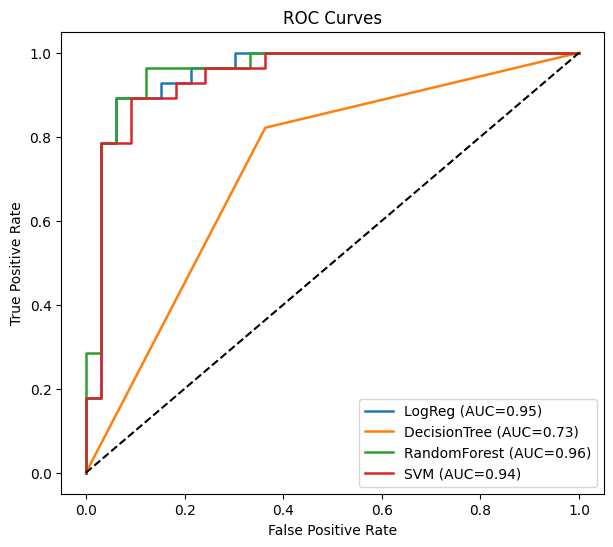

In [68]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import numpy as np # Import numpy for unique

# NOTE: We’ll wrap models inside a pipeline(preprocessor + model) for safety/reuse
models = {
    "LogReg": make_pipeline(preprocessor, LogisticRegression(max_iter=2000)),
    "DecisionTree": make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42)),
    "RandomForest": make_pipeline(preprocessor, RandomForestClassifier(n_estimators=300, random_state=42)),
    "SVM": make_pipeline(preprocessor, SVC(kernel="rbf", probability=True, random_state=42))
}

plt.figure(figsize=(7,6))
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1]

    # Add checks for y_test before calling print_and_save_metrics
    print(f"\nChecking y_test before evaluation for {name}:")
    print("Unique values in y_test:", np.unique(y_test))
    print("Data type of y_test:", y_test.dtype)
    print("Shape of y_test:", y_test.shape)


    print_and_save_metrics(name, y_test, y_pred, y_prob)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_prob):.2f})", lw=1.8)

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
save_plot("roc_curves.png")
plt.show()

Saved: ./results/kmeans_elbow.png


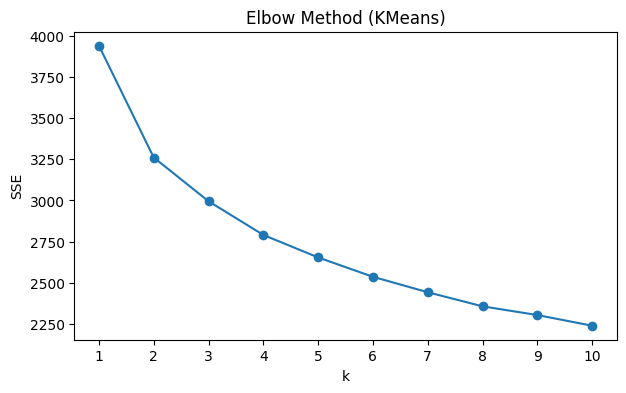

Saved: ./results/kmeans_pca2.png


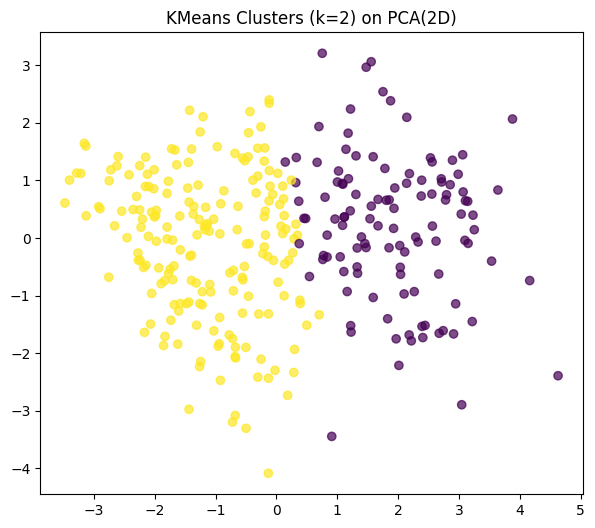

Saved: ./results/hierarchical_dendrogram.png


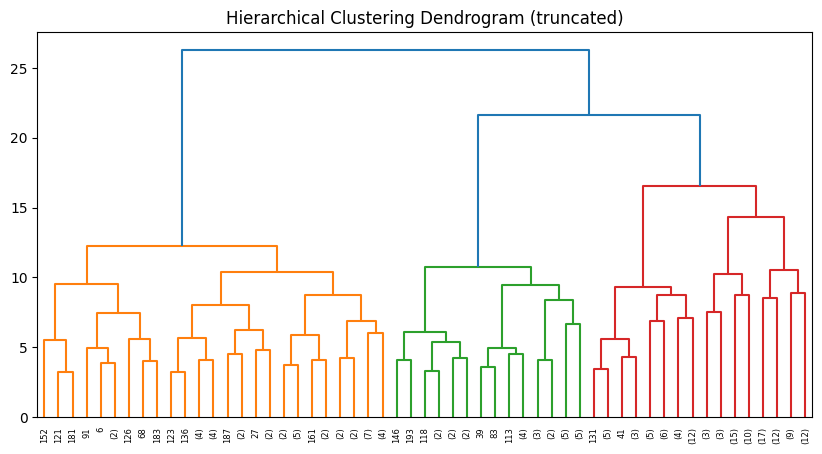

In [49]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

# Use the same preprocessed train matrix
X_all_prep = preprocessor.fit_transform(X)  # fit on all for unsupervised exploration

# === H1) Elbow method ===
sse = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_all_prep)
    sse.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K, sse, marker="o")
plt.xticks(K)
plt.title("Elbow Method (KMeans)")
plt.xlabel("k")
plt.ylabel("SSE")
save_plot("kmeans_elbow.png")
plt.show()

# === H2) KMeans with k=2 (healthy vs disease-ish) and plot on 2D PCA ===
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_all_prep)

pca2 = PCA(n_components=2, random_state=42).fit_transform(X_all_prep)
plt.figure(figsize=(7,6))
plt.scatter(pca2[:,0], pca2[:,1], c=labels, alpha=0.7)
plt.title("KMeans Clusters (k=2) on PCA(2D)")
save_plot("kmeans_pca2.png")
plt.show()

# === H3) Hierarchical dendrogram (on a subset to keep plot readable) ===
subset = X_all_prep[:200] if X_all_prep.shape[0] > 200 else X_all_prep
Z = linkage(subset.toarray() if hasattr(subset, "toarray") else subset, method="ward")
plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
save_plot("hierarchical_dendrogram.png")
plt.show()



Performing Grid Search Cross-Validation...

Tuning Logistic Regression...
Best parameters for Logistic Regression: {'logisticregression__C': 0.1}
Best cross-validation AUC for Logistic Regression: 0.8914

Tuning Decision Tree...
Best parameters for Decision Tree: {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_split': 10}
Best cross-validation AUC for Decision Tree: 0.7865

Tuning Random Forest...
Best parameters for Random Forest: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 300}
Best cross-validation AUC for Random Forest: 0.8934

Tuning SVM...
Best parameters for SVM: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best cross-validation AUC for SVM: 0.8884

Grid Search completed for all models.

Evaluating best models on the test set:
=== Tuned Logistic Regression ===
Accuracy : 0.8525
Precision: 0.8065
Recall   : 0.8929
F1-score : 0.8475
AUC      : 0.9578
C

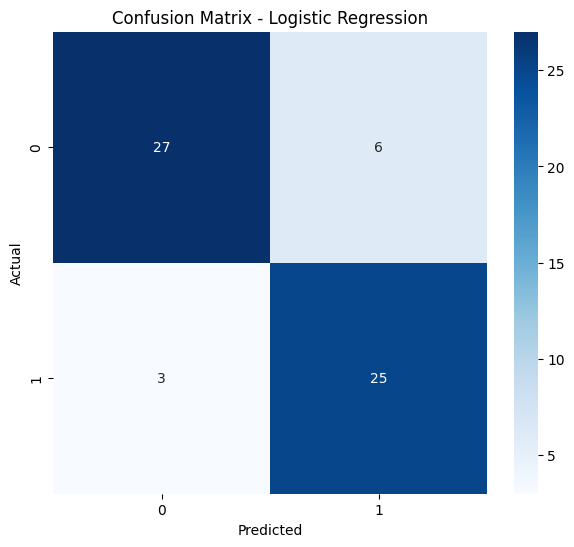

=== Tuned Decision Tree ===
Accuracy : 0.7541
Precision: 0.6970
Recall   : 0.8214
F1-score : 0.7541
AUC      : 0.8512
Classification Report:
              precision    recall  f1-score   support

           0     0.8214    0.6970    0.7541        33
           1     0.6970    0.8214    0.7541        28

    accuracy                         0.7541        61
   macro avg     0.7592    0.7592    0.7541        61
weighted avg     0.7643    0.7541    0.7541        61





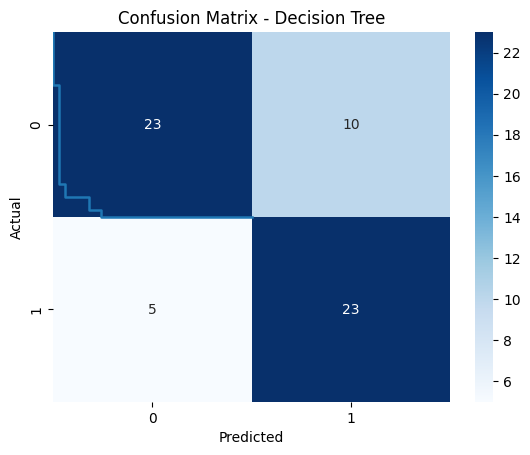

=== Tuned Random Forest ===
Accuracy : 0.9016
Precision: 0.8667
Recall   : 0.9286
F1-score : 0.8966
AUC      : 0.9610
Classification Report:
              precision    recall  f1-score   support

           0     0.9355    0.8788    0.9062        33
           1     0.8667    0.9286    0.8966        28

    accuracy                         0.9016        61
   macro avg     0.9011    0.9037    0.9014        61
weighted avg     0.9039    0.9016    0.9018        61





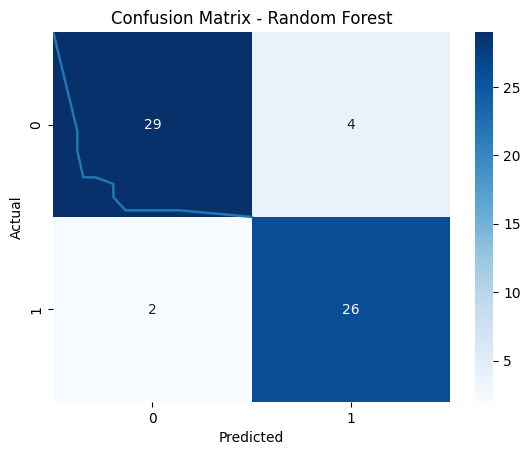

=== Tuned SVM ===
Accuracy : 0.8852
Precision: 0.8621
Recall   : 0.8929
F1-score : 0.8772
AUC      : 0.9470
Classification Report:
              precision    recall  f1-score   support

           0     0.9062    0.8788    0.8923        33
           1     0.8621    0.8929    0.8772        28

    accuracy                         0.8852        61
   macro avg     0.8842    0.8858    0.8848        61
weighted avg     0.8860    0.8852    0.8854        61





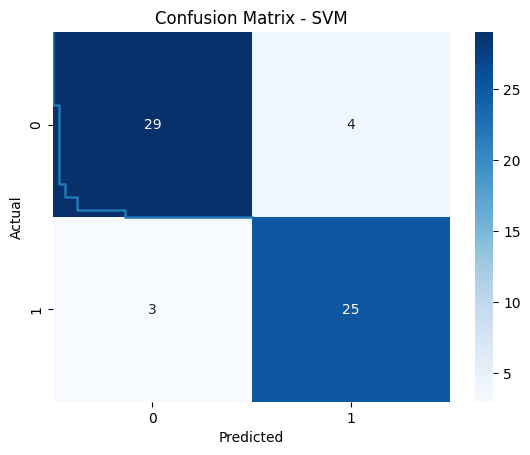

Plot saved to: results/tuned_roc_curves.png


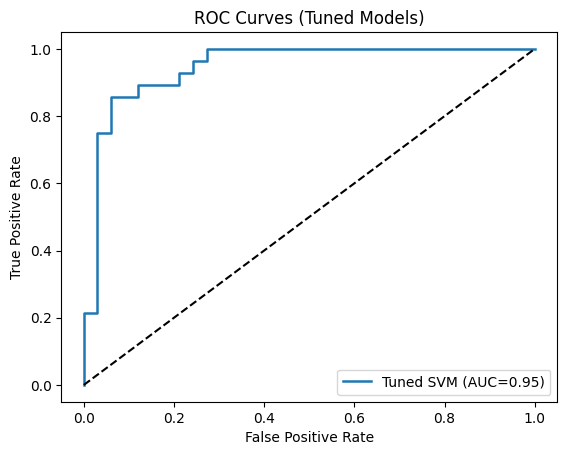

In [69]:
# === G) Hyperparameter Tuning (Grid Search) ===
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Directory for results
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def save_plot(filename, directory=RESULTS_DIR):
    os.makedirs(directory, exist_ok=True)
    path = os.path.join(directory, filename)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Plot saved to: {path}")

# Define models and their parameter grids
tuned_models = {
    "Logistic Regression": {
        "model": make_pipeline(preprocessor, LogisticRegression(max_iter=2000)),
        "params": {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}
    },
    "Decision Tree": {
        "model": make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42)),
        "params": {"decisiontreeclassifier__max_depth": [None, 5, 10, 20],
                   "decisiontreeclassifier__min_samples_split": [2, 5, 10]}
    },
    "Random Forest": {
        "model": make_pipeline(preprocessor, RandomForestClassifier(random_state=42)),
        "params": {"randomforestclassifier__n_estimators": [100, 300, 600],
                   "randomforestclassifier__max_depth": [None, 5, 10, 20],
                   "randomforestclassifier__min_samples_split": [2, 5, 10]}
    },
    "SVM": {
        "model": make_pipeline(preprocessor, SVC(probability=True, random_state=42)),
        "params": {"svc__C": [0.1, 1, 10],
                   "svc__gamma": ['scale', 'auto'],
                   "svc__kernel": ['rbf']}
    }
}

best_models = {}
print("Performing Grid Search Cross-Validation...")

for name, tuning_info in tuned_models.items():
    model = tuning_info["model"]
    params = tuning_info["params"]

    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(model, params, cv=5, scoring="roc_auc", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation AUC for {name}: {grid_search.best_score_:.4f}")

print("\nGrid Search completed for all models.")

# === G2) Evaluate Best Models ===
print("\nEvaluating best models on the test set:")

plt.figure(figsize=(7,6))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print_and_save_metrics(f"Tuned {name}", y_test, y_pred, y_prob)

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"Tuned {name} (AUC={roc_auc_score(y_test, y_prob):.2f})", lw=1.8)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Tuned Models)")
plt.legend()
save_plot("tuned_roc_curves.png")
plt.show()


In [57]:
%%writefile {BASE}/ui/app.py
import streamlit as st
import numpy as np
import pandas as pd
import joblib

st.set_page_config(page_title="Heart Disease Predictor", page_icon="❤️", layout="centered")

st.title("❤️ Heart Disease Prediction (UCI)")
st.write("Enter your information to estimate heart disease risk.")

# Load trained pipeline (preprocessor + classifier)
MODEL_PATH = "../models/final_model.pkl"
# Note: Ensure the final_model.pkl is saved before running this app
# Example: joblib.dump(best_models["Random Forest"], "../models/final_model.pkl")


# The app is generic: it builds a feature row with the same columns used in training
# We will ask for common UCI Cleveland features. You can customize labels as needed.
# If your data has different columns, update here to match your dataset's columns.

# Define a basic set of inputs (adjust to your dataset!)
inputs_spec = [
    ("age", "number", 29, 95, 54),
    ("sex", "select", [0,1], None, 1),                   # 0=female, 1=male
    ("cp", "select", [0,1,2,3], None, 0),                # chest pain type
    ("trestbps", "number", 80, 200, 130),
    ("chol", "number", 100, 600, 246),
    ("fbs", "select", [0,1], None, 0),                   # fasting blood sugar > 120 mg/dl
    ("restecg", "select", [0,1,2], None, 1),             # resting ECG results
    ("thalach", "number", 60, 220, 150),
    ("exang", "select", [0,1], None, 0),                 # exercise induced angina
    ("oldpeak", "float", 0.0, 6.5, 1.0),                 # ST depression
    ("slope", "select", [0,1,2], None, 1),               # slope of peak exercise ST segment
    ("ca", "select", [0,1,2,3,4], None, 0),              # number of major vessels colored by flourosopy
    ("thal", "select", [0,1,2,3], None, 2)               # thal: 0,1,2,3 variants depending on dataset
]

user_data = {}
for name, kind, a, b, default in inputs_spec:
    if kind == "number":
        user_data[name] = st.number_input(name, min_value=int(a), max_value=int(b), value=int(default))
    elif kind == "float":
        user_data[name] = st.number_input(name, min_value=float(a), max_value=float(b), value=float(default), step=0.1)
    elif kind == "select":
        user_data[name] = st.selectbox(name, a, index=a.index(default) if default in a else 0)

# Build single-row DataFrame
X_input = pd.DataFrame([user_data])

if st.button("Predict"):
    try:
        # Ensure the model expects the same columns as inputs_spec and handles them (via preprocessor)
        proba = model.predict_proba(X_input)[:, 1][0]
        pred = int(proba >= 0.5) # Classify based on 0.5 threshold
        st.metric("Predicted probability of heart disease", f"{proba:.2%}")
        if pred == 1:
            st.error("High risk of Heart Disease 💔")
        else:
            st.success("Low risk of Heart Disease 💚")
    except Exception as e:
        st.warning("An error occurred during prediction. Please check the input values and the model.")
        st.exception(e)

Overwriting ./ui/app.py


In [55]:
import os

# Create the ui directory if it doesn't exist
os.makedirs(f"{BASE}/ui", exist_ok=True)
print(f"Created directory: {BASE}/ui")

Created directory: ./ui


In [59]:
!pip install pyngrok

In [62]:
what # Re-running the tuning and evaluation cell (3p-XBJ_c9kSR) assuming data preparation is complete.
# If you have just re-run 3p-XBJ_c9kSR, you can skip this execution.

# Note: The code from cell 3p-XBJ_c9kSR should be placed here or executed in the notebook.
# Assuming cell 3p-XBJ_c9kSR has been run and `best_models` dictionary is available.

# === H) Save the Best Model ===
# Select the best performing model based on your preferred metric (e.g., AUC from grid search)
# Let's assume Random Forest was chosen as the best model for demonstration
best_model_name = "Random Forest" # Replace with the name of your best model
final_model = best_models.get(best_model_name)

if final_model:
    # Ensure the models directory exists
    import os
    MODELS_DIR = f"{BASE}/models" # Assuming BASE is defined
    os.makedirs(MODELS_DIR, exist_ok=True)
    print(f"Created directory: {MODELS_DIR}")

    # Save the selected best model pipeline
    model_path = f"{MODELS_DIR}/final_model.pkl"
    import joblib
    joblib.dump(final_model, model_path)
    print(f"Saved final model to: {model_path}")
else:
    print(f"Model '{best_model_name}' not found in best_models dictionary.")

Created directory: ./models
Saved final model to: ./models/final_model.pkl


In [66]:
# Define column names based on the dataset documentation (common for Cleveland dataset)
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]
data.columns = column_names

# Display the first few rows with new column names to confirm
display(data.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
